In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid', {'grid.linestyle': '--', 'grid.alpha': 0.4, 'axes.formatter.limits': (-8, 9)})
sns.set_palette('icefire')

import warnings
warnings.filterwarnings('ignore')

I have pretrained the model with large daily historical price of 300 tickers from 2000 to 2019. It is used for finetuning the 10-ticker from crypto assets and here I am to investigate the effect. 

Reference best performance was results for fold 3 and 192 sequence length. I have two variants of pretrained model, with exact architecture: 128 and 192 sequence lengths.

Load performance results from baseline

In [2]:
cols = ['epoch', 'train_loss', 'valid_loss', 'train_mse', 'valid_mse', 'lr']
dfs = []

fold = 3
for t in range(1, 10):
    for max_len in ['_128', '_192', '_256']:
        try:
            path = f'../models/hslstm_baseline_t{t}{max_len}/results{fold}.pkl'
            if max_len == '_256': 
                path = f'../models/hslstm4x_t{t}{max_len}/results{fold}.pkl'
            with open(path, 'rb') as f:
                data = pickle.load(f)
                df = pd.DataFrame(data, columns = cols)
                df['fold'] = fold
                df['lookahead'] = t
                df['max_len'] = 64 if max_len == '' else int(max_len.replace('_', ''))
                df['is_best'] = 0
                df.loc[df['valid_loss'] == min(df['valid_loss']), 'is_best'] = 1
                if max_len != '_256':
                    df['train_loss'] **= 0.5
                    df['valid_loss'] **= 0.5
                dfs.append(df)
        except:
            pass
        
df = pd.concat(dfs)
df['pretrained'] = 'None'
df['train_loss'] *= 100
df['valid_loss'] *= 100
df.shape
        

(969, 11)

Load results of finetuned models with pretrained weights

In [3]:
dfs = []
fold = 3
pretrain_timesteps = ['t1', 't3']
for p in pretrain_timesteps:
    for t in range(1, 10):
        for max_len in ['_128', '_192', '_256']:
            try:
                path = f'../models/pretrained_{p}_hslstm_t{t}{max_len}/results{fold}.pkl'
                if max_len == '_256':
                    path = f'../models/pretrained_{p}_hslstm4x_t{t}{max_len}/results{fold}.pkl'
                with open(path, 'rb') as f:
                    data = pickle.load(f)
                    mdf = pd.DataFrame(data, columns = cols)
                    mdf['fold'] = fold
                    mdf['lookahead'] = t
                    mdf['max_len'] = 64 if max_len == '' else int(max_len.replace('_', ''))
                    mdf['is_best'] = 0
                    mdf['pretrained'] = f'pretrained_{p}'
                    mdf.loc[mdf['valid_loss'] == min(mdf['valid_loss']), 'is_best'] = 1
                    dfs.append(mdf)
            except:
                pass

mdf = pd.concat(dfs)
mdf['train_loss'] *= 100            # losses are rmse
mdf['valid_loss'] *= 100
mdf.shape


(606, 11)

In [4]:
d = pd.concat([df, mdf])
d.shape

(1575, 11)

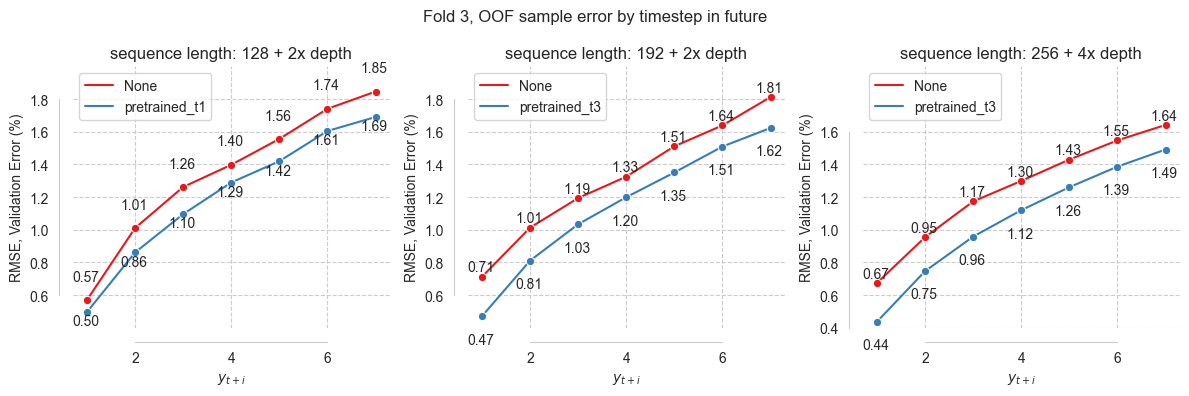

In [12]:
#agg = df.groupby(by = ['fold', 'lookahead', 'max_len'])[['train_loss', 'valid_loss']].min().reset_index()
agg = d[d['is_best'] == 1]
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.lineplot(data = agg[agg['max_len'] == 128], x = 'lookahead', y = 'valid_loss', marker = 'o', palette='Set1', ax = ax[0], hue = 'pretrained')
sns.lineplot(data = agg[agg['max_len'] == 192], x = 'lookahead', y = 'valid_loss', marker = 'o', palette='Set1', ax = ax[1], hue = 'pretrained')
sns.lineplot(data = agg[agg['max_len'] == 256], x = 'lookahead', y = 'valid_loss', marker = 'o', palette='Set1', ax = ax[2], hue = 'pretrained')
for i,max_len in zip([0, 1, 2], [f'{128} + 2x depth', f'{192} + 2x depth', f'{256} + 4x depth']):
    sns.despine(offset=10, trim=True, ax = ax[i])
    ax[i].set_ylim([0.4, 2.0])
    ax[i].set_xlabel('$y_{t+i}$'); ax[i].set_ylabel('RMSE, Validation Error (%)')
    ax[i].set_title(f'sequence length: {max_len}')
    ax[i].legend(loc='upper left')
    for idx, line in enumerate(ax[i].lines):
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            ax[i].text(x + 0.25, y + (0.1 if idx == 0 else -0.1),
                       f'{y:.2f}', 
                       ha='right', 
                       va= 'bottom' if i == 0 else 'top', 
                       fontsize=10)

plt.suptitle('Fold 3, OOF sample error by timestep in future')
plt.tight_layout()
plt.show()

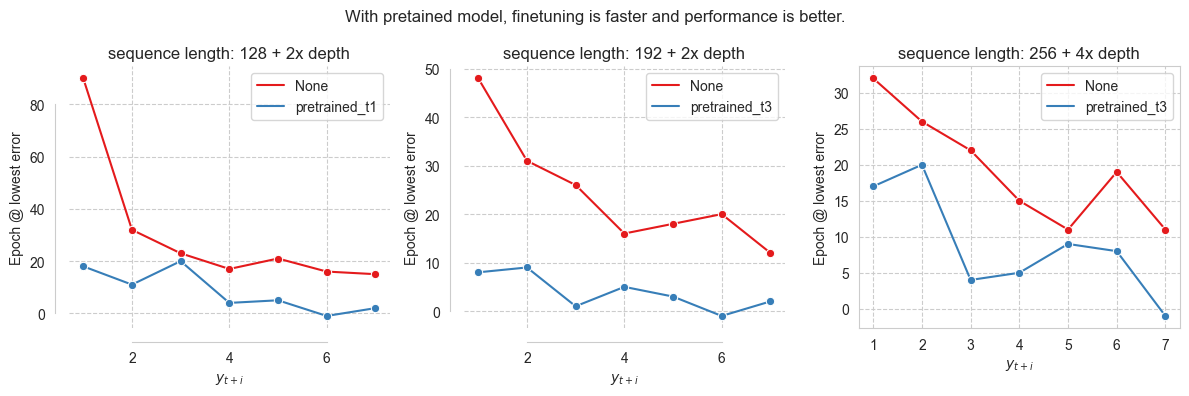

In [6]:
#agg = df.groupby(by = ['fold', 'lookahead', 'max_len'])[['train_loss', 'valid_loss']].min().reset_index()
agg = d[d['is_best'] == 1]
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.lineplot(data = agg[agg['max_len'] == 128], x = 'lookahead', y = 'epoch', marker = 'o', palette='Set1', ax = ax[0], hue = 'pretrained')
sns.lineplot(data = agg[agg['max_len'] == 192], x = 'lookahead', y = 'epoch', marker = 'o', palette='Set1', ax = ax[1], hue = 'pretrained')
sns.lineplot(data = agg[agg['max_len'] == 256], x = 'lookahead', y = 'epoch', marker = 'o', palette='Set1', ax = ax[2], hue = 'pretrained')
sns.despine(offset=10, trim=True, ax = ax[0])
sns.despine(offset=10, trim=True, ax = ax[1])
for i,max_len in zip([0, 1, 2], [f'{128} + 2x depth', f'{192} + 2x depth', f'{256} + 4x depth']):
    ax[i].set_xlabel('$y_{t+i}$'); ax[i].set_ylabel('Epoch @ lowest error')
    ax[i].set_title(f'sequence length: {max_len}')
    ax[i].legend(loc='upper right')

plt.suptitle('With pretained model, finetuning is faster and performance is better.')
plt.tight_layout()
plt.show()

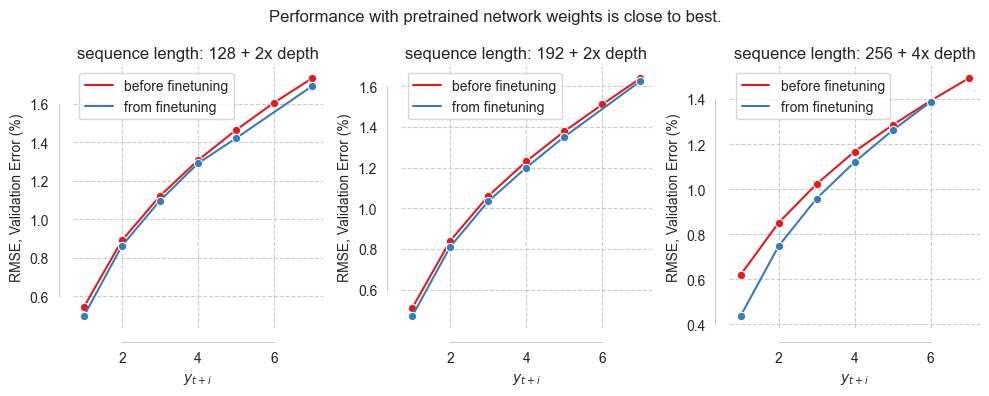

In [10]:
p = d[((d['epoch'] == -1) | (d['is_best'] == 1))]
agg = p[p['pretrained'] != 'None']
agg['stage'] = agg['epoch'].apply(lambda x: 'before finetuning' if x == -1 else 'from finetuning')

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
sns.lineplot(data = agg[agg['max_len'] == 128], x = 'lookahead', y = 'valid_loss', marker = 'o', palette='Set1', ax = ax[0], hue = 'stage')
sns.lineplot(data = agg[agg['max_len'] == 192], x = 'lookahead', y = 'valid_loss', marker = 'o', palette='Set1', ax = ax[1], hue = 'stage')
sns.lineplot(data = agg[agg['max_len'] == 256], x = 'lookahead', y = 'valid_loss', marker = 'o', palette='Set1', ax = ax[2], hue = 'stage')
sns.despine(offset=10, trim=True, ax = ax[0])
sns.despine(offset=10, trim=True, ax = ax[1])
sns.despine(offset=10, trim=True, ax = ax[2])
for i,max_len in zip([0, 1, 2], [f'{128} + 2x depth', f'{192} + 2x depth', f'{256} + 4x depth']):
    ax[i].set_xlabel('$y_{t+i}$'); ax[i].set_ylabel('RMSE, Validation Error (%)')
    ax[i].set_title(f'sequence length: {max_len}')
    ax[i].legend(loc='upper left')

plt.suptitle('Performance with pretrained network weights is close to best.')
plt.tight_layout()
plt.show()

In [8]:
tickers = ['ATOM', 'AVAX', 'BNB', 'BTC', 'ETC', 'ETH', 'LINK', 'LTC', 'SOL', 'XMR']
dict_agg = []
bars = pd.read_parquet('../data/train_volume_bars.pqt')
bars['start'] = pd.to_datetime(bars['start'])
for t in tickers:
    b = bars[bars['ticker'] == t]
    b.sort_values(by = 'start', ascending = True, inplace = True)
    avg, std = np.mean(b['close'].pct_change()) * 100, np.std(b['close'].pct_change()) * 100
    dict_agg.append((t, avg, std))
    
agg = pd.DataFrame(dict_agg, columns = ['ticker', 'pct_chg_mean', 'pct_chg_std'])
agg['pct_chg_mean'].mean(), agg['pct_chg_std'].mean()


(0.05256108891956716, 2.8353265952961815)